# 보팅 분류기

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, StackingClassifier

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [5]:
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
# 보팅 분류기 생성
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=7)

voting_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)],
                              voting='soft')

In [9]:
voting_clf

VotingClassifier(estimators=[('LR', LogisticRegression(solver='liblinear')),
                             ('KNN', KNeighborsClassifier(n_neighbors=7))],
                 voting='soft')

In [10]:
# 데이터 분할

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=0)

In [15]:
# 분류기 학습 - 예측 - 평가
voting_clf.fit(X_train, y_train)
vo_pred = voting_clf.predict(X_test)
accuracy_score(y_test, vo_pred)

0.956140350877193

In [16]:
print(classification_report(y_test, vo_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        47
           1       0.96      0.97      0.96        67

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [17]:
confusion_matrix(y_test, vo_pred)

array([[44,  3],
       [ 2, 65]])

In [18]:
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        47
           1       0.98      0.94      0.96        67

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [20]:
confusion_matrix(y_test, lr_pred)

array([[46,  1],
       [ 4, 63]])

In [19]:
knn_clf.fit(X_train, y_train)
knn_pred = knn_clf.predict(X_test)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        47
           1       0.96      0.96      0.96        67

    accuracy                           0.95       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114



In [21]:
confusion_matrix(y_test, knn_pred)

array([[44,  3],
       [ 3, 64]])

In [24]:
def get_new_feature_name_df(old_feature_name_df):
    # 중복된 feature 이름 처리: 이름 뒤에 _0, _1, ... 등의 suffix 추가
    feature_dup_df = old_feature_name_df.groupby('column_name').cumcount()
    new_feature_name_df = old_feature_name_df.copy()
    new_feature_name_df['column_name'] = new_feature_name_df['column_name'] + "_" + feature_dup_df.astype(str)
    return new_feature_name_df

def get_human_dataset(base_path='./UCI-HAR_Dataset/'):
    # 피처 이름 로딩
    feature_path = base_path + 'features.txt'
    feature_name_df = pd.read_csv(feature_path, sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복 피처명 처리
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_names = new_feature_name_df['column_name'].tolist()

    # 학습/테스트 데이터 로딩
    X_train = pd.read_csv(base_path + 'train/X_train.txt', sep='\s+', names=feature_names)
    X_test = pd.read_csv(base_path + 'test/X_test.txt', sep='\s+', names=feature_names)

    y_train = pd.read_csv(base_path + 'train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv(base_path + 'test/y_test.txt', sep='\s+', header=None, names=['action'])

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = get_human_dataset()

print(X_train.shape, X_test.shape)
print(y_train['action'].value_counts())

(7352, 561) (2947, 561)
action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


# 랜덤포레스트 모델 만들기

In [68]:
rf_clf = RandomForestClassifier(random_state=42, max_depth=8)

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
accuracy_score(y_test, rf_pred)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9178825924669155

In [69]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':[13, 14, 15, 16, 17], 'min_samples_split':[1, 2, 3], 'n_estimators':[100]}
grid_rf = GridSearchCV(rf_clf, param_grid=params, cv=5, refit=True)
grid_rf.fit(X_train, y_train)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, random_state=42),
             param_grid={'max_depth': [13, 14, 15, 16, 17],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [100]})

In [70]:
grid_rf.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 100}

In [71]:
best_rf = grid_rf.best_estimator_
pred = best_rf.predict(X_test)
accuracy_score(y_test, pred)

0.9287410926365796

In [72]:
# {'max_depth': 9, 'min_samples_split': 4}
# {'max_depth': 11, 'min_samples_split': 3}    0.9222938581608415

In [95]:
rf = RandomForestClassifier(random_state=42, n_estimators=350, max_depth=20, min_samples_split=3, n_jobs=-1)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9334916864608076

In [134]:
# 피처 중요도 출력
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(10, top_n * 0.4))  # 피처 수에 따라 자동 높이 조절

    plt.barh(range(top_n), importances[indices][::-1], align='center')
    plt.yticks(range(top_n), np.array(feature_names)[indices][::-1])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()

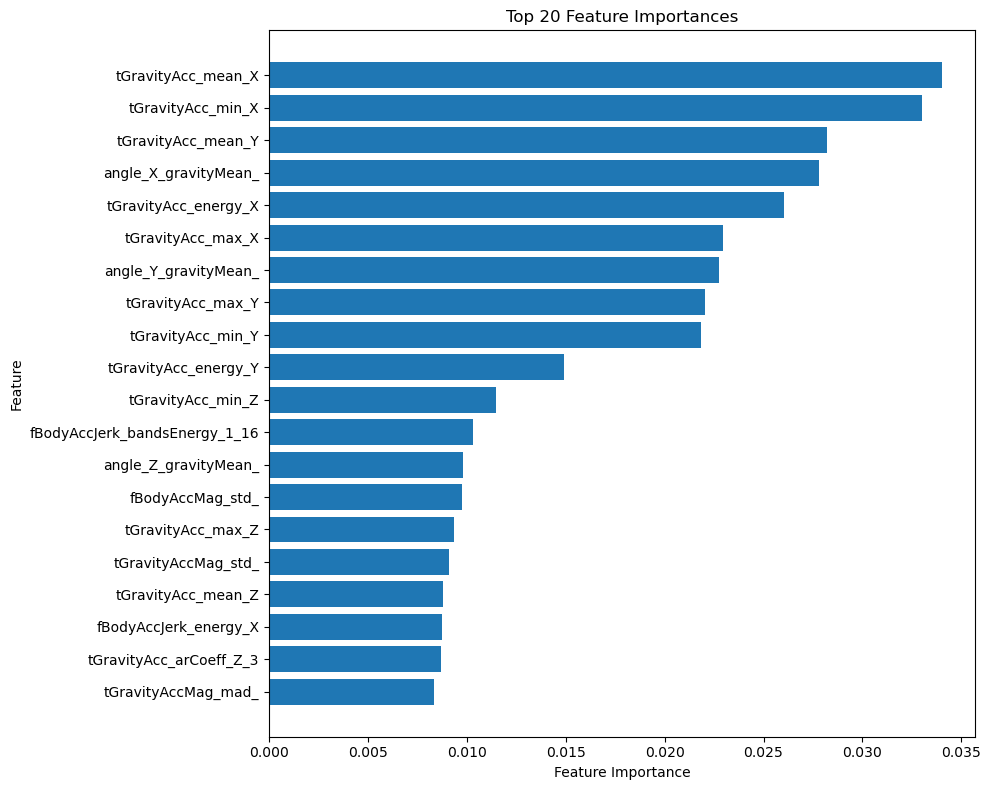

In [135]:
plot_feature_importances(rf, feature_names=X_train.columns)

# GBM Gradient Boosting Machine

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = get_human_dataset()

print(X_train.shape, X_test.shape)
print(y_train['action'].value_counts())

(7352, 561) (2947, 561)
action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [97]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
accuracy_score(y_test, gb_pred)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9389209365456397

In [133]:
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           1       0.94      0.98      0.96       496
           2       0.93      0.93      0.93       471
           3       0.97      0.92      0.95       420
           4       0.93      0.85      0.89       491
           5       0.87      0.94      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



## XGBoost

In [98]:
import xgboost

In [107]:
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = get_human_dataset()
X_train.shape, y_train.shape

((7352, 561), (7352, 1))

In [108]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # Series → 1D array
y_test_encoded = le.transform(y_test)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [115]:
from xgboost import XGBClassifier
evals = [(X_test, y_test_encoded)]
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, use_label_encoder=False)
xgb.fit(X_train, y_train_encoded, early_stopping_rounds=40, eval_set=evals, eval_metric='mlogloss', verbose=True)
xgb_pred = xgb.predict(X_test)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.58932
[1]	validation_0-mlogloss:1.43267
[2]	validation_0-mlogloss:1.30322
[3]	validation_0-mlogloss:1.19383
[4]	validation_0-mlogloss:1.10067
[5]	validation_0-mlogloss:1.01957
[6]	validation_0-mlogloss:0.94662
[7]	validation_0-mlogloss:0.88249
[8]	validation_0-mlogloss:0.82727
[9]	validation_0-mlogloss:0.77601
[10]	validation_0-mlogloss:0.72925
[11]	validation_0-mlogloss:0.68936
[12]	validation_0-mlogloss:0.65128
[13]	validation_0-mlogloss:0.61844
[14]	validation_0-mlogloss:0.58748
[15]	validation_0-mlogloss:0.55894
[16]	validation_0-mlogloss:0.53410
[17]	validation_0-mlogloss:0.50956
[18]	validation_0-mlogloss:0.48868
[19]	validation_0-mlogloss:0.46809
[20]	validation_0-mlogloss:0.45075
[21]	validation_0-mlogloss:0.43385
[22]	validation_0-mlogloss:0.41768
[23]	validation_0-mlogloss:0.40316
[24]	validation_0-mlogloss:0.38937
[25]	validation_0-mlogloss:0.37645
[26]	validation_0-mlogloss:0.36394
[27]	validation_0-mlogloss:0.35407
[28]	validation_0-mlogloss:0.3

In [116]:
print(classification_report(y_test_encoded, xgb_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       496
           1       0.94      0.94      0.94       471
           2       0.98      0.94      0.96       420
           3       0.94      0.87      0.90       491
           4       0.89      0.95      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



## lightGBM

In [99]:
import lightgbm

In [126]:
import re
def clean_feature_name(name):
    # 특수문자 제거: 괄호, 콤마, 하이픈 등
    return re.sub('[^A-Za-z0-9_]+', '_', name)

In [127]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    # new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
    #   
    # 중복 이름 처리 + 특수문자 제거
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(
        lambda x: clean_feature_name(x[0] + ('_' + str(x[1]) if x[1] > 0 else '')), axis=1
    )
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [128]:
X_train, X_test, y_train, y_test = get_human_dataset()

print(X_train.shape, X_test.shape)
print(y_train['action'].value_counts())

C:\Users\Admin\AppData\Local\Temp\ipykernel_6488\3037849969.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: clean_feature_name(x[0] + ('_' + str(x[1]) if x[1] > 0 else '')), axis=1


(7352, 561) (2947, 561)
action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [131]:
from lightgbm import LGBMClassifier
evals = [(X_test, y_test_encoded)]
lgbm = LGBMClassifier(n_estimators=400)
lgbm.fit(X_train, y_train_encoded, early_stopping_rounds=40, eval_set=evals, eval_metric='logloss', verbose=True)
lgbm_pred = lgbm.predict(X_test)

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.4404
[2]	valid_0's multi_logloss: 1.21574
[3]	valid_0's multi_logloss: 1.04795
[4]	valid_0's multi_logloss: 0.913299
[5]	valid_0's multi_logloss: 0.812686
[6]	valid_0's multi_logloss: 0.725964
[7]	valid_0's multi_logloss: 0.652995
[8]	valid_0's multi_logloss: 0.591598
[9]	valid_0's multi_logloss: 0.539383
[10]	valid_0's multi_logloss: 0.499944
[11]	valid_0's multi_logloss: 0.462273
[12]	valid_0's multi_logloss: 0.429676
[13]	valid_0's multi_logloss: 0.401908
[14]	valid_0's multi_logloss: 0.377718
[15]	valid_0's multi_logloss: 0.357455
[16]	valid_0's multi_logloss: 0.339918
[17]	valid_0's multi_logloss: 0.325799
[18]	valid_0's multi_logloss: 0.314716
[19]	valid_0's multi_logloss: 0.301914
[20]	valid_0's multi_logloss: 0.292755
[21]	valid_0's multi_logloss: 0.284754
[22]	valid_0's multi_logloss: 0.276745
[23]	valid_0's multi_logloss: 0.270387
[24]	valid_0's multi_logloss: 0.265765
[25]	valid_0's multi_logloss: 0.260089
[26]	valid_0's multi_logloss: 0.256178

In [132]:
print(classification_report(y_test_encoded, lgbm_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       496
           1       0.93      0.90      0.92       471
           2       0.95      0.92      0.94       420
           3       0.92      0.82      0.87       491
           4       0.85      0.94      0.89       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947

